In [40]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os


In [41]:
import pickle
import sys
from pathlib import Path

# Añadir el directorio raíz del proyecto a sys.path
module_path = Path('/Users/Cesar/Desktop/Proyecto-CSG/').resolve()
if module_path not in sys.path:
    sys.path.append(str(module_path))

# Añadir el directorio que contiene 'new_spectral_metric' a sys.path
new_spectral_metric_path = module_path / '/Users/Cesar/Desktop/Proyecto-CSG/new_spectral_metric/'
if new_spectral_metric_path not in sys.path:
    sys.path.append(str(new_spectral_metric_path))

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from new_spectral_metric.new_estimator import CumulativeGradientEstimator
from new_spectral_metric.new_visualize import make_graph
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from pathlib import Path


In [42]:
# Lectura de dataset

directorio_dataset = ('../Datasets/Cats and dogs - train')
directorio_dataset = pathlib.Path(directorio_dataset)

imagenes_cats = ('../Datasets/Cats and dogs - train/cats')
imagenes_cats = pathlib.Path(imagenes_cats)

imagenes_dogs = ('../Datasets/Cats and dogs - train/dogs')
imagenes_dogs = pathlib.Path(imagenes_dogs)

total_dataset = len(list(directorio_dataset.glob('*/*.png')))  # Cuenta la cantidad de imagenes del dataset (Aqui busca en las subcarpetas del directorio del dataset)
total_cats = len(list(imagenes_cats.glob('*.png')))  # Cuenta la cantidad de imagenes de la clase original (Aqui busca directamente en la carpeta cat)
total_dogs = len(list(imagenes_dogs.glob('*.png')))  # Cuenta la cantidad de imagenes de la clase corrupta (Aqui busca directamente en la carpeta cat_c_defocus_blur)

print(f"Total imagenes dataset: {total_dataset}")
print(f"Total imagenes cats: {total_cats}")
print(f"Total imagenes dogs: {total_dogs}")

Total imagenes dataset: 5001
Total imagenes cats: 1
Total imagenes dogs: 5000


In [43]:
# Dimensiones de imagen y tamaño de batch
img_height = 32
img_width = 32
#batch_size = len(list(data_dir.glob('*/*.png'))) # leer todas las imágenes al tiempo
batch_size = total_dataset

In [44]:

# Data splitting (entrenamiento y validación)
all_images_in_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  directorio_dataset,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5001 files belonging to 2 classes.


In [45]:
class_names = all_images_in_dataset.class_names
num_classes = len(class_names)  # get the number of the classes
print(f"Número de clases: {num_classes}")
print(f"Los nombres de las clases son: {class_names}")



Número de clases: 2
Los nombres de las clases son: ['cats', 'dogs']


In [46]:
# Revisar etiquetas de las imágenes
for images, labels in all_images_in_dataset:
    labels = labels.numpy() if hasattr(labels, 'numpy') else labels
    for label in labels:
        assert label in [0, 1], f"Etiqueta inesperada {label} en la imagen."


In [47]:
for images, labels0 in all_images_in_dataset.take(1):  # only take first element of dataset
    numpy_all_images = images.numpy()  # convertir el tensor de imágenes en un arreglo de numpy y ahora contiene las imágenes del conjunto de datos en formato de numpy.
    numpy_all_labels = labels0.numpy()  # convierte el tensor de etiquetas en un arreglo de numpy y ahora contiene las etiquetas del conjunto de datos en formato de numpy

numpy_all_images /= 255.0  # Scale the features to the [0, 1] range
print(numpy_all_images.shape)

(5001, 32, 32, 3)


c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\

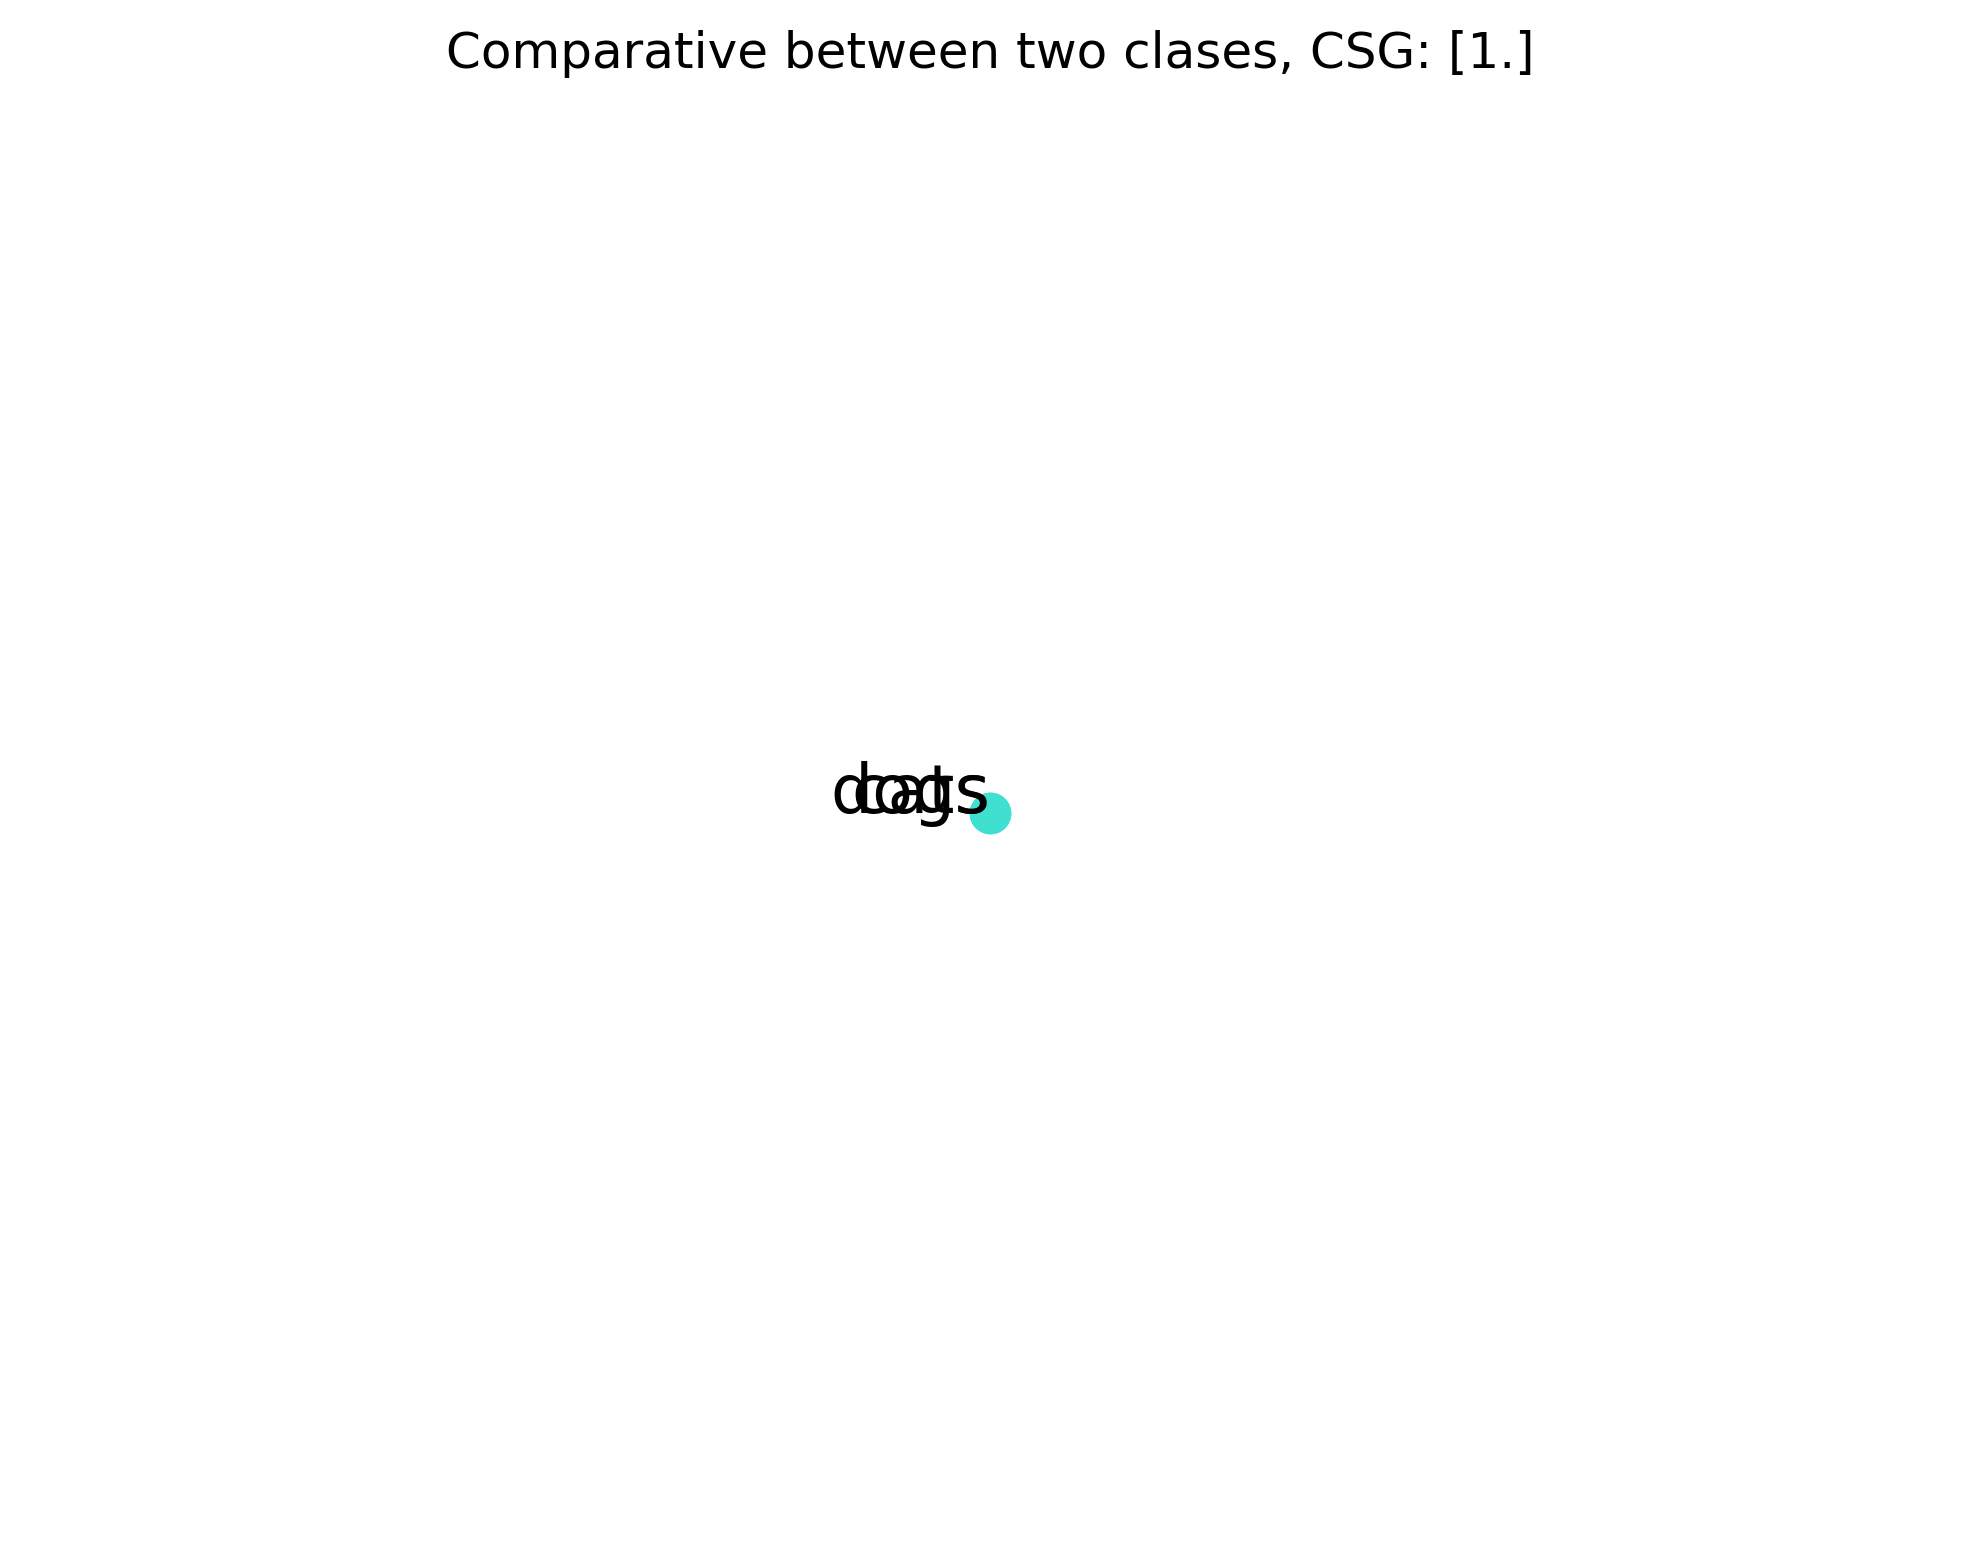

In [48]:
# Aplanar las imágenes
fully_dataset = numpy_all_images.reshape((numpy_all_images.shape[0], numpy_all_images.shape[1]*numpy_all_images.shape[2]*numpy_all_images.shape[3])) # es un arreglo bidimensional donde cada fila representa una imagen y cada columna representa un píxel de la imagen
fully_labels = numpy_all_labels.reshape(numpy_all_labels.shape[0],)


# Inicializar el estimador
estimator = CumulativeGradientEstimator(M_sample=348, k_nearest=10)
estimator.fit(data=fully_dataset, target=fully_labels)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

make_graph(estimator.difference, title="Comparative between two clases, CSG: "+str(csg), classes=class_names)

In [49]:
# Aplanar las imágenes
fully_dataset = numpy_all_images.reshape((numpy_all_images.shape[0], numpy_all_images.shape[1]*numpy_all_images.shape[2]*numpy_all_images.shape[3])) # es un arreglo bidimensional donde cada fila representa una imagen y cada columna representa un píxel de la imagen
fully_labels = numpy_all_labels.reshape(numpy_all_labels.shape[0],)

# Verificar si hay NaNs en fully_dataset
print("Hay NaNs en fully_dataset:", np.isnan(fully_dataset).any())

# Verificar las clases en fully_labels
print("Clases en fully_labels:", np.unique(fully_labels))

Hay NaNs en fully_dataset: False
Clases en fully_labels: [0 1]


In [50]:
# from sklearn.impute import SimpleImputer

# # Inicializar el estimador
# estimator = CumulativeGradientEstimator(M_sample=348, k_nearest=10)
# estimator.fit(data=fully_dataset, target=fully_labels)
# csg = estimator.csg  # The actual complexity values.
# estimator.evals, estimator.evecs  # The eigenvalues and vectors.

# # Imputar los valores NaN en la matriz de diferencias
# imputer = SimpleImputer(strategy='mean')
# difference_imputed = imputer.fit_transform(estimator.difference)

# # Crear el gráfico con la matriz imputada
# make_graph(difference_imputed, title="Comparative between two classes, CSG: " + str(csg), classes=class_names)


In [51]:
# Ordena los pares de clases en orden de similitud ascendente (menos similar primero)
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))
pairs = [(original,corrupto) for original,corrupto in pairs if original != corrupto]

similitud_de_clases = pairs[0]
original, corrupto = similitud_de_clases  # Pares de clases menos similares

print("Calculo de similitud entre clases")
lst = []
for idx, (original,corrupto) in enumerate(pairs[::2][:1]):
    lst.append({"Clases a comparar" : f"{class_names[original]} <> {class_names[corrupto]}", "Similitud": estimator.W[original,corrupto]})
print(pd.DataFrame(lst))
print(estimator.W.shape)

Calculo de similitud entre clases
  Clases a comparar  Similitud
0      cats <> dogs        1.0
(2, 2)


	Nombre del archivo: felis_catus_s_001221.png, Clase: dogs, Similitud: 0.0680
	Nombre del archivo: domestic_cat_s_001530.png, Clase: dogs, Similitud: 0.0680


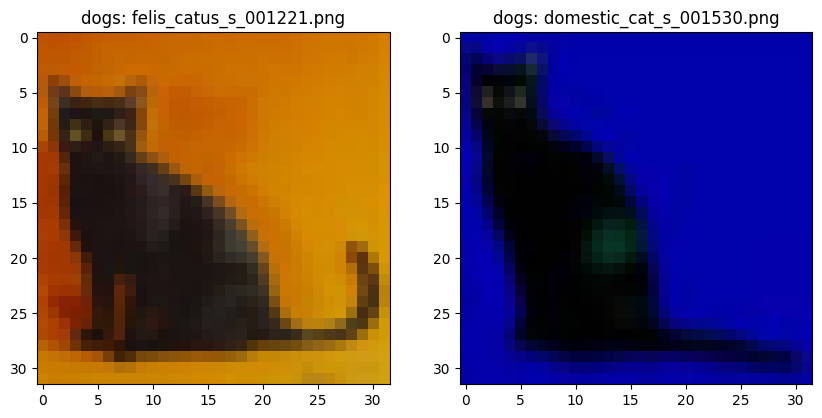

	Nombre del archivo: house_cat_s_002093.png, Clase: dogs, Similitud: 0.0757
	Nombre del archivo: tomcat_s_001532.png, Clase: dogs, Similitud: 0.0757


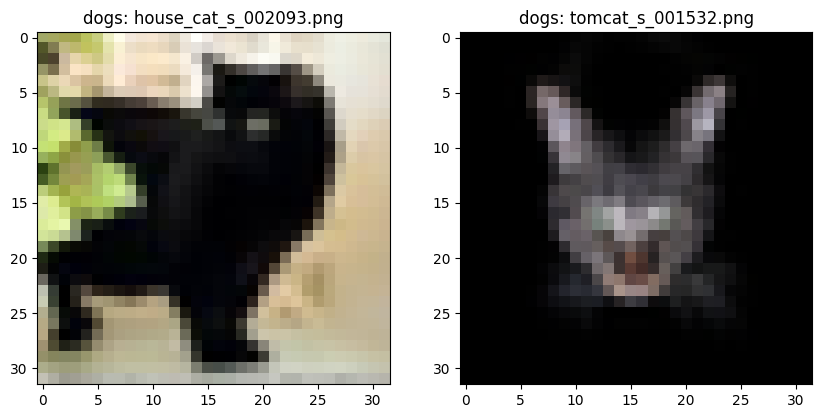

	Nombre del archivo: domestic_cat_s_001530.png, Clase: dogs, Similitud: 0.0788
	Nombre del archivo: house_cat_s_001328.png, Clase: dogs, Similitud: 0.0788


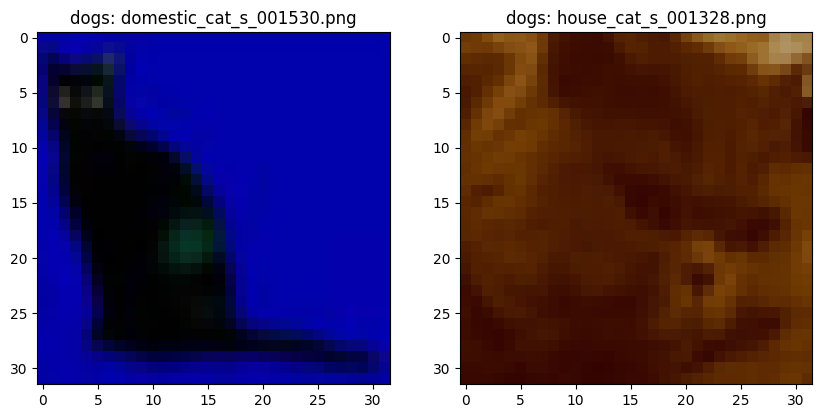

	Nombre del archivo: tomcat_s_001532.png, Clase: dogs, Similitud: 0.0832
	Nombre del archivo: cat_s_002807.png, Clase: dogs, Similitud: 0.0832


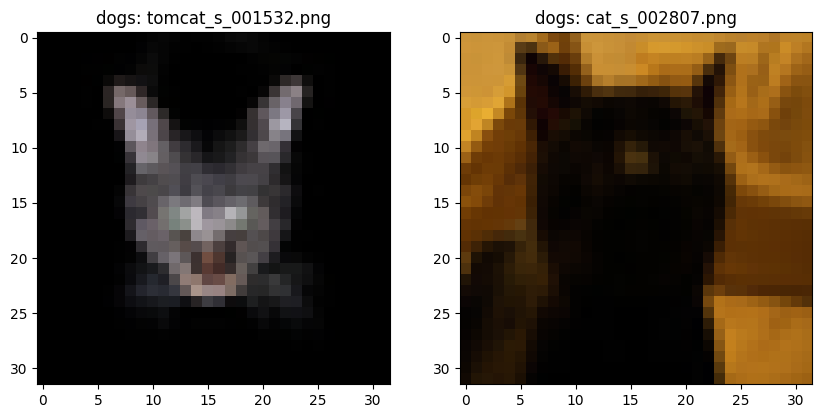

	Nombre del archivo: tomcat_s_001532.png, Clase: dogs, Similitud: 0.0903
	Nombre del archivo: felis_domesticus_s_000312.png, Clase: dogs, Similitud: 0.0903


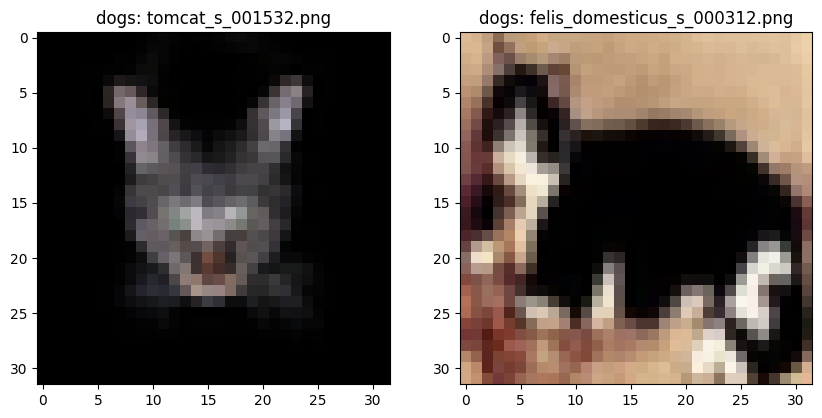

	Nombre del archivo: house_cat_s_001728.png, Clase: dogs, Similitud: 0.0922
	Nombre del archivo: tomcat_s_001532.png, Clase: dogs, Similitud: 0.0922


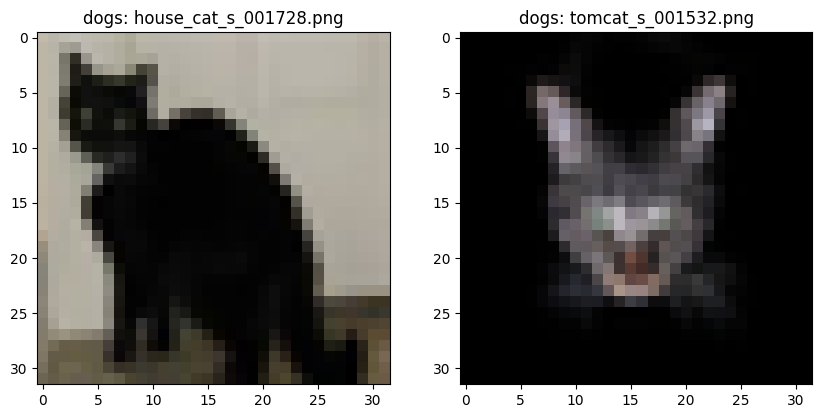

	Nombre del archivo: house_cat_s_001663.png, Clase: dogs, Similitud: 0.0944
	Nombre del archivo: domestic_cat_s_001530.png, Clase: dogs, Similitud: 0.0944


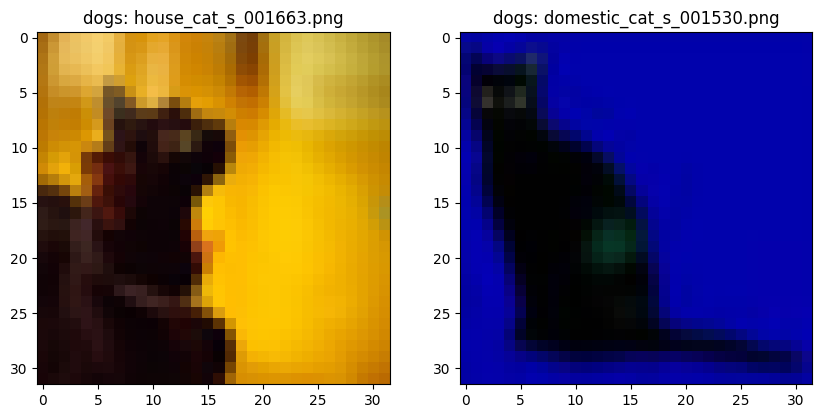

	Nombre del archivo: felis_domesticus_s_000065.png, Clase: dogs, Similitud: 0.0994
	Nombre del archivo: house_cat_s_001728.png, Clase: dogs, Similitud: 0.0994


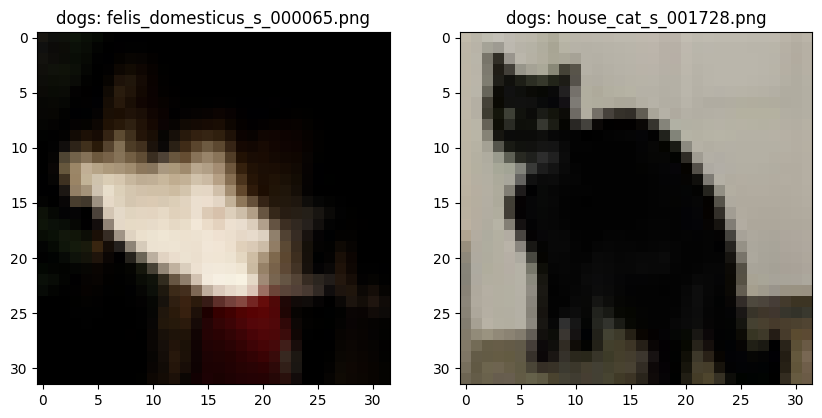

	Nombre del archivo: tomcat_s_001532.png, Clase: dogs, Similitud: 0.0996
	Nombre del archivo: cat_s_002785.png, Clase: dogs, Similitud: 0.0996


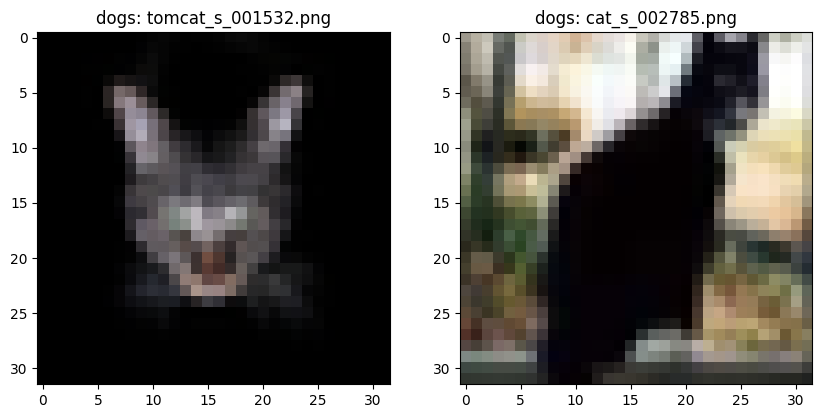

	Nombre del archivo: domestic_cat_s_001530.png, Clase: dogs, Similitud: 0.1001
	Nombre del archivo: felis_catus_s_001396.png, Clase: dogs, Similitud: 0.1001


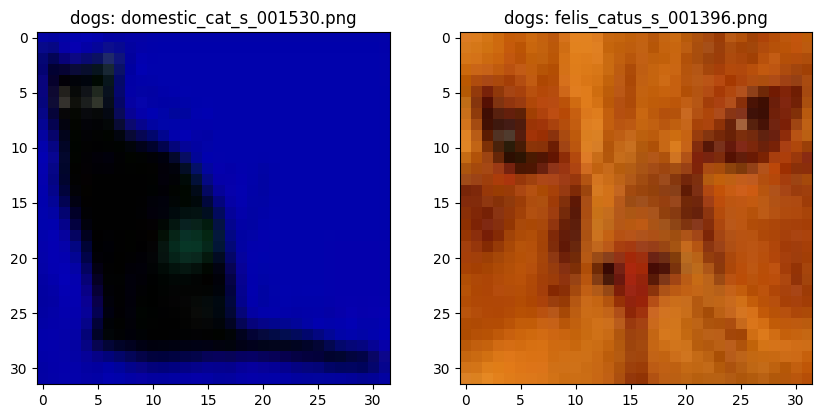

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Acceder a la matriz M después de ajustar el modelo
M = estimator.M

# Ordenar los índices según las similitudes (de menor a mayor)
least_similar_indices = np.argsort(M, axis=None)

# Conjunto para llevar un registro de los archivos ya mostrados
shown_files = set()
count = 0

# Crear un diccionario de nombres de archivo y clases
filenames_dict = {i: f for i, f in enumerate(directorio_dataset.glob('*/*.png'))}
class_names_list = ['cats' if label == 0 else 'dogs' for label in fully_labels]

# Mostrar las 10 muestras menos similares
for idx in least_similar_indices:
    if count >= 10:
        break

    # Convertir el índice plano a índice 2D
    idx_2d = np.unravel_index(idx, M.shape)

    # Obtener los índices de las muestras en el dataset
    source_idx = idx_2d[0]
    target_idx = idx_2d[1]

    # Verificar que los índices estén dentro de los límites del dataset
    if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):
        source_filename = filenames_dict[int(source_idx)]
        target_filename = filenames_dict[int(target_idx)]

        # Verificar si el par ya ha sido mostrado
        if (source_filename, target_filename) not in shown_files and (target_filename, source_filename) not in shown_files:
            shown_files.add((source_filename, target_filename))
            shown_files.add((target_filename, source_filename))

            value = M[idx_2d]
            print(f"\tNombre del archivo: {source_filename.name}, Clase: {class_names_list[source_idx]}, Similitud: {value:.4f}")
            print(f"\tNombre del archivo: {target_filename.name}, Clase: {class_names_list[target_idx]}, Similitud: {value:.4f}")
            
            # Visualizar las imágenes de los pares menos similares
            img_source = plt.imread(source_filename)
            img_target = plt.imread(target_filename)
            
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].imshow(img_source)
            axs[0].set_title(f"{class_names_list[source_idx]}: {source_filename.name}")
            axs[1].imshow(img_target)
            axs[1].set_title(f"{class_names_list[target_idx]}: {target_filename.name}")
            plt.show()

            count += 1

cats <> dogs
	Nombre del archivo: 49994.png, Clase: cats, Similitud: 0.7993
	Nombre del archivo: house_cat_s_001099.png, Clase: dogs, Similitud: 0.7993


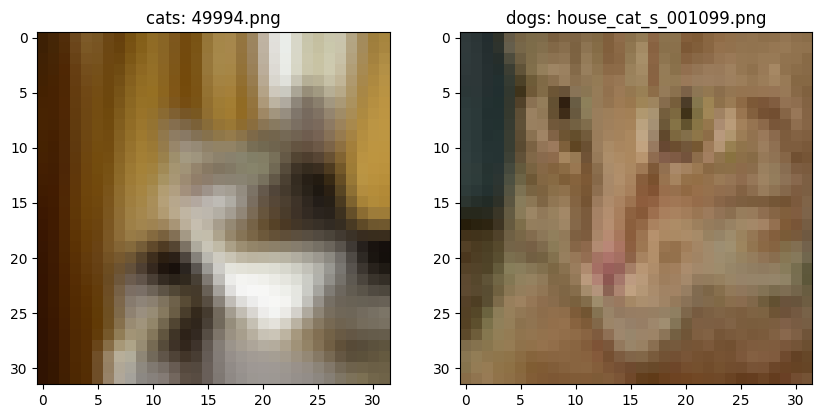

Clase: 0, Número de muestras: 1
Clase: 1, Número de muestras: 348


In [53]:
import matplotlib.pyplot as plt

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f for i, f in enumerate(directorio_dataset.glob('*/*.png'))}

def show_most_similar_using_P(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener la matriz de similitud de las muestras entre las clases
    P = estimator.P[(source_intent, target_intent)]
    
    # Ordenar los índices según las similitudes (de mayor a menor)
    most_similar_indices = np.argsort(P, axis=None)[::-1]
    
    # Conjunto para llevar un registro de los archivos ya mostrados
    shown_files = set()
    count = 0
    
    for idx in most_similar_indices:
        if count >= 10:
            break
        
        # Convertir el índice plano a índice 2D
        idx_2d = np.unravel_index(idx, P.shape)
        
        # Obtener los índices de las muestras en el dataset
        source_idx = estimator.class_indices[source_intent][idx_2d[0]]
        target_idx = estimator.class_indices[target_intent][idx_2d[1]]
        
        # Verificar que los índices estén dentro de los límites del dataset
        if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):
            source_filename = filenames_dict[int(source_idx)]
            target_filename = filenames_dict[int(target_idx)]
            
            if source_filename not in shown_files and target_filename not in shown_files:
                shown_files.add(source_filename)
                shown_files.add(target_filename)
                
                value = P[idx_2d]
                print(f"\tNombre del archivo: {source_filename.name}, Clase: {class_names[source_intent]}, Similitud: {value:.4f}")
                print(f"\tNombre del archivo: {target_filename.name}, Clase: {class_names[target_intent]}, Similitud: {value:.4f}")
                
                img_source = plt.imread(source_filename)
                img_target = plt.imread(target_filename)
                
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                axs[0].imshow(img_source)
                axs[0].set_title(f"{class_names[source_intent]}: {source_filename.name}")
                axs[1].imshow(img_target)
                axs[1].set_title(f"{class_names[target_intent]}: {target_filename.name}")
                plt.show()
                
                count += 1

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]

# Mostrar las más similares usando la matriz de pares (P)
show_most_similar_using_P(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)

for class_name, indices in estimator.class_indices.items():
    print(f"Clase: {class_name}, Número de muestras: {len(indices)}")
    

In [54]:
import scipy

# Normalizar las rutas de los archivos en filenames_dict
filenames_dict = {idx: os.path.normpath(filename) for idx, filename in filenames_dict.items()}

# Eliminar o comentar la verificación del contenido de filenames_dict
# print("Contenido de filenames_dict (normalizado):")
# for idx, filename in filenames_dict.items():
#     print(f"Índice: {idx}, Nombre del archivo: {filename}")

# Definir las clases (esto se asume basado en tu contexto)
class_cats = 0
class_dogs = 1

# Obtener los índices de las muestras de las clases 'cats' y 'dogs'
cats_indices = estimator.class_indices[class_cats]
dogs_indices = estimator.class_indices[class_dogs]

# Buscar el índice que corresponde al archivo 'cat_605.jpg'
target_filename = os.path.normpath(r'..\Datasets\Cats and dogs - train\cats\cat_548.jpg')
for idx in cats_indices:
    if filenames_dict[idx] == target_filename:
        first_cat_index = idx
        break
else:
    raise ValueError("No se encontró 'cat_605.jpg' en la clase 'cats'.")

# Verificar que se encontró la primera muestra de 'cats' correctamente
print(f"Primera muestra de 'cats': Índice {first_cat_index}, Nombre del archivo: {os.path.basename(filenames_dict[first_cat_index])}")

# Seleccionar la primera muestra de la clase 'cats'
sample_cat = fully_dataset[first_cat_index]

# Crear un array para almacenar las similitudes con las muestras de 'dogs'
similarities = []

# Calcular la similitud (disimilitud) entre la muestra de 'cats' y todas las muestras de 'dogs'
for dog_index in dogs_indices:
    sample_dog = fully_dataset[dog_index]
    similarity = 1 - scipy.spatial.distance.braycurtis(sample_cat, sample_dog)
    similarities.append((similarity, dog_index))

# Ordenar las similitudes en orden descendente (más similar primero)
similarities.sort(reverse=True)

# Mostrar las 10 muestras más similares
print("Las 10 muestras más similares (más cercanas a 1 en la métrica Bray-Curtis):")
for i, (similarity, dog_index) in enumerate(similarities[:10]):
    print(f"{i+1}. Similitud: {similarity:.4f}, Índice de la muestra de 'dogs': {dog_index}, Nombre del archivo: {os.path.basename(filenames_dict[dog_index])}")

# Mostrar las imágenes de las 10 muestras más similares
for similarity, dog_index in similarities[:10]:
    sample_dog_filename = os.path.basename(filenames_dict[dog_index])
    print(f"\nSimilitud: {similarity:.4f}")
    print(f"Nombre del archivo: {sample_dog_filename}")
    
    img_cat = fully_dataset[first_cat_index].reshape(img_height, img_width, 3)  # Reconstruir la imagen del array a una imagen 256x256x3
    img_dog = fully_dataset[dog_index].reshape(img_height, img_width, 3)  # Reconstruir la imagen del array a una imagen 256x256x3
    
    # Mostrar las imágenes usando matplotlib
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img_cat)
    axs[0].set_title(f"Cat: {os.path.basename(filenames_dict[first_cat_index])}")
    axs[1].imshow(img_dog)
    axs[1].set_title(f"Dog: {sample_dog_filename}")
    plt.show()



ValueError: No se encontró 'cat_605.jpg' en la clase 'cats'.

Primera muestra de 'cats': Índice 290, Nombre del archivo: cat_548.jpg
Las 10 muestras menos similares (más cercanas a 0 en la métrica Bray-Curtis):
1. Similitud: 0.4966, Índice de la muestra de 'dogs': 570, Nombre del archivo: dog_437.jpg
2. Similitud: 0.4939, Índice de la muestra de 'dogs': 528, Nombre del archivo: dog_367.jpg
3. Similitud: 0.4801, Índice de la muestra de 'dogs': 490, Nombre del archivo: dog_315.jpg
4. Similitud: 0.4653, Índice de la muestra de 'dogs': 524, Nombre del archivo: dog_361.jpg
5. Similitud: 0.4494, Índice de la muestra de 'dogs': 457, Nombre del archivo: dog_262.jpg
6. Similitud: 0.3858, Índice de la muestra de 'dogs': 365, Nombre del archivo: dog_128.jpg
7. Similitud: 0.3728, Índice de la muestra de 'dogs': 434, Nombre del archivo: dog_23.jpg
8. Similitud: 0.3721, Índice de la muestra de 'dogs': 437, Nombre del archivo: dog_232.jpg
9. Similitud: 0.3636, Índice de la muestra de 'dogs': 640, Nombre del archivo: dog_543.jpg
10. Similitud: 0.2393, Índice de 

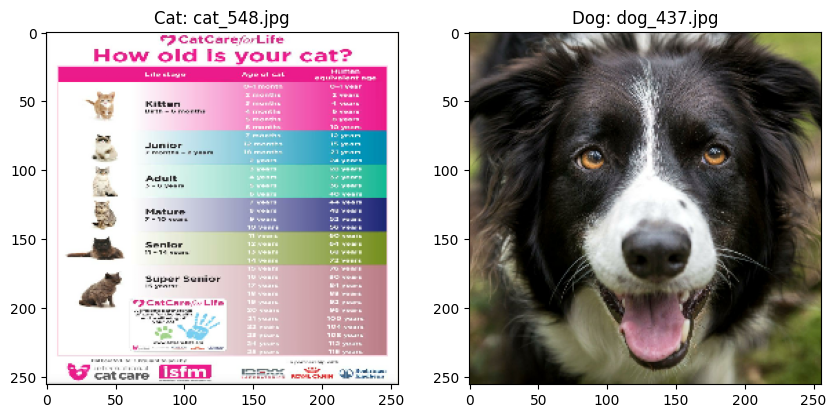


Similitud: 0.4939
Nombre del archivo: dog_367.jpg


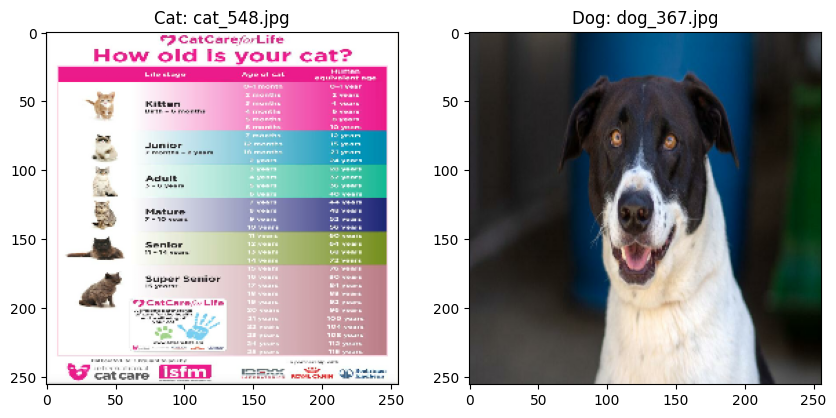


Similitud: 0.4801
Nombre del archivo: dog_315.jpg


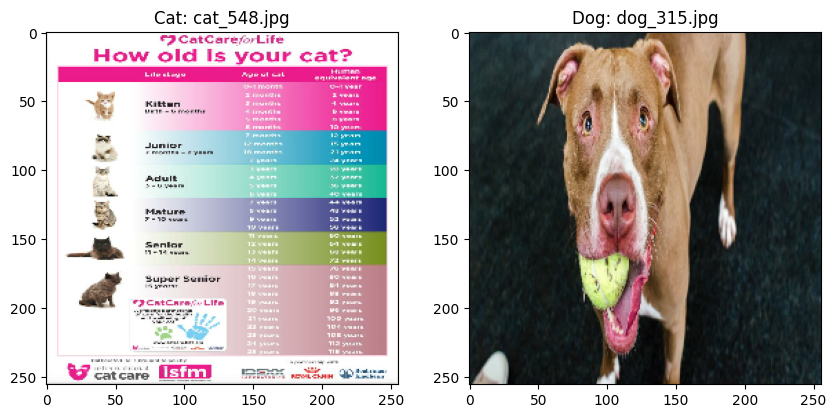


Similitud: 0.4653
Nombre del archivo: dog_361.jpg


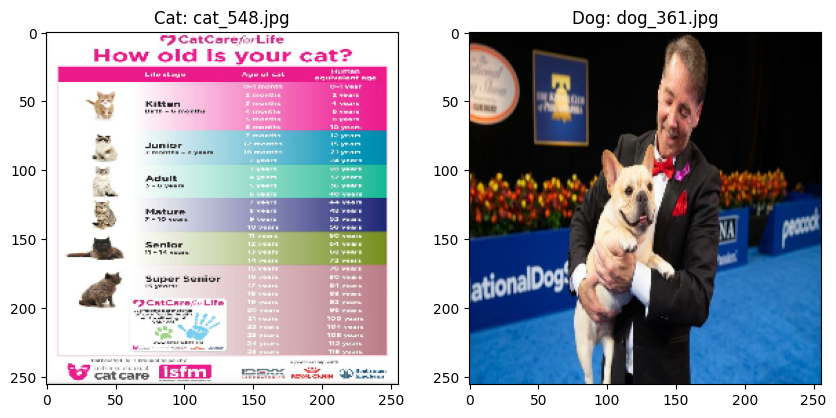


Similitud: 0.4494
Nombre del archivo: dog_262.jpg


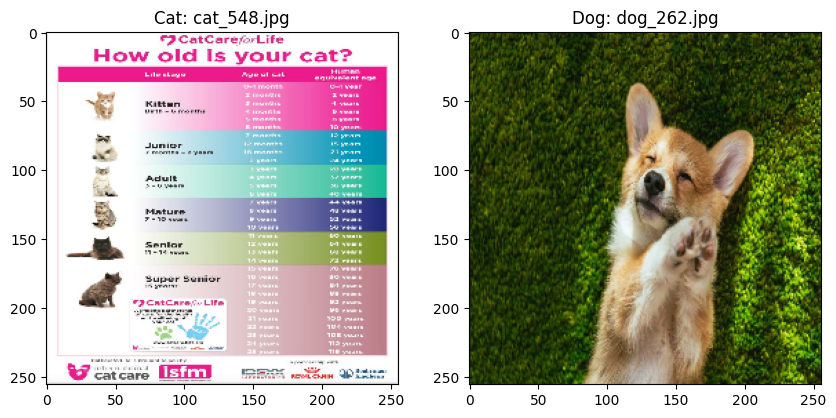


Similitud: 0.3858
Nombre del archivo: dog_128.jpg


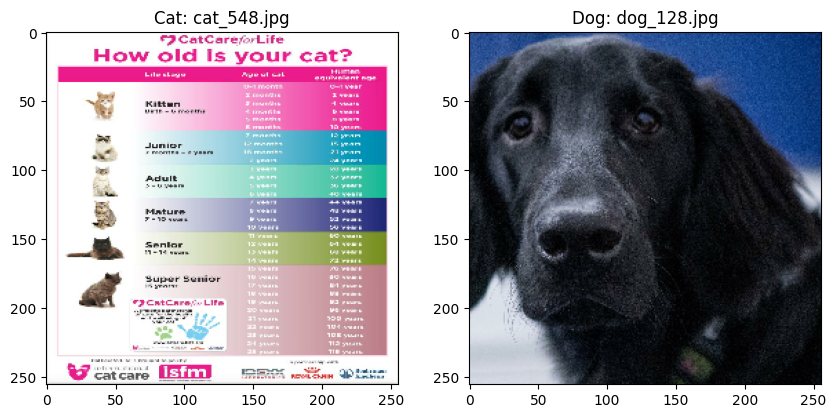


Similitud: 0.3728
Nombre del archivo: dog_23.jpg


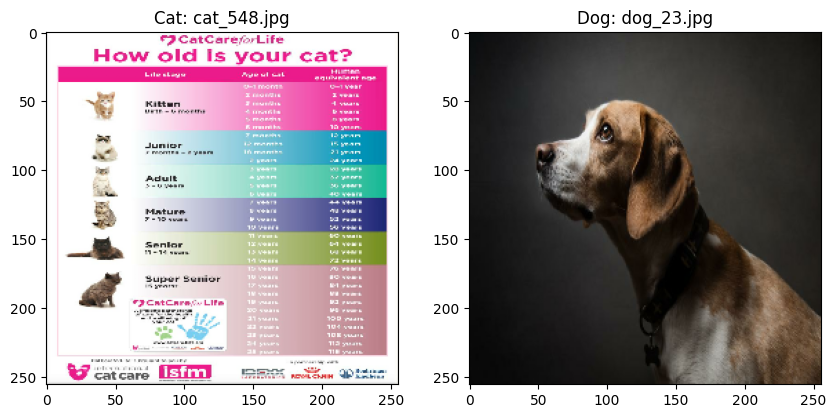


Similitud: 0.3721
Nombre del archivo: dog_232.jpg


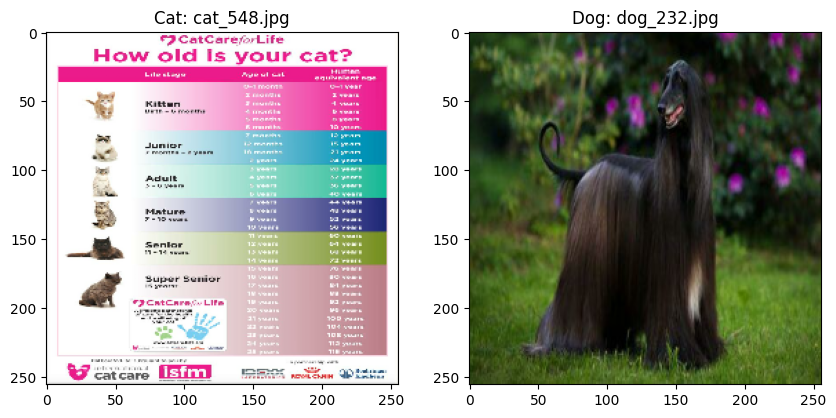


Similitud: 0.3636
Nombre del archivo: dog_543.jpg


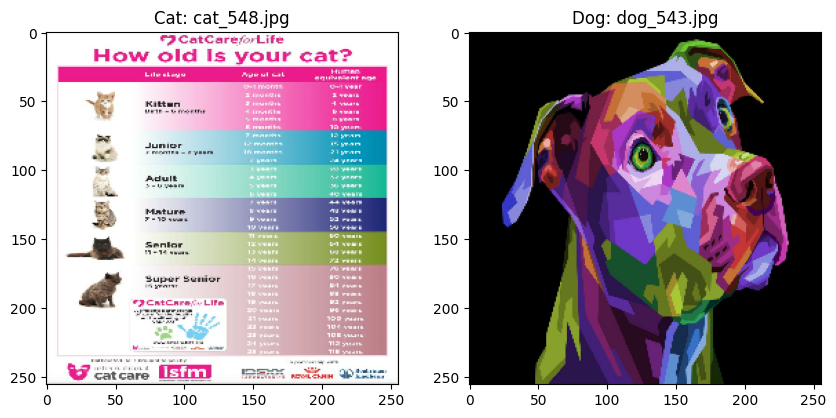


Similitud: 0.2393
Nombre del archivo: dog_505.jpg


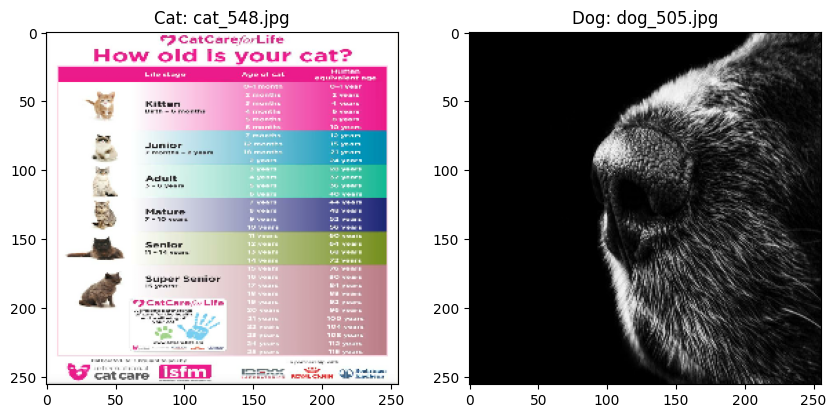

In [ ]:
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
import os

# Normalizar las rutas de los archivos en filenames_dict
filenames_dict = {idx: os.path.normpath(filename) for idx, filename in filenames_dict.items()}

# Eliminar o comentar la verificación del contenido de filenames_dict
# print("Contenido de filenames_dict (normalizado):")
# for idx, filename in filenames_dict.items():
#     print(f"Índice: {idx}, Nombre del archivo: {filename}")

# Definir las clases (esto se asume basado en tu contexto)
class_cats = 0
class_dogs = 1

# Obtener los índices de las muestras de las clases 'cats' y 'dogs'
cats_indices = estimator.class_indices[class_cats]
dogs_indices = estimator.class_indices[class_dogs]

# Buscar el índice que corresponde al archivo 'cat_605.jpg'
target_filename = os.path.normpath(r'..\Datasets\Cats and dogs - train\cats\cat_548.jpg')
for idx in cats_indices:
    if filenames_dict[idx] == target_filename:
        first_cat_index = idx
        break
else:
    raise ValueError("No se encontró 'cat_605.jpg' en la clase 'cats'.")

# Verificar que se encontró la primera muestra de 'cats' correctamente
print(f"Primera muestra de 'cats': Índice {first_cat_index}, Nombre del archivo: {os.path.basename(filenames_dict[first_cat_index])}")

# Seleccionar la primera muestra de la clase 'cats'
sample_cat = fully_dataset[first_cat_index]

# Crear un array para almacenar las similitudes con las muestras de 'dogs'
similarities = []

# Calcular la similitud (disimilitud) entre la muestra de 'cats' y todas las muestras de 'dogs'
for dog_index in dogs_indices:
    sample_dog = fully_dataset[dog_index]
    similarity = 1 - scipy.spatial.distance.braycurtis(sample_cat, sample_dog)
    similarities.append((similarity, dog_index))

# Ordenar las similitudes en orden descendente (más similar primero)
similarities.sort(reverse=True)

# Mostrar las 10 muestras menos similares
print("Las 10 muestras menos similares (más cercanas a 0 en la métrica Bray-Curtis):")
for i, (similarity, dog_index) in enumerate(similarities[-10:], start=1):
    print(f"{i}. Similitud: {similarity:.4f}, Índice de la muestra de 'dogs': {dog_index}, Nombre del archivo: {os.path.basename(filenames_dict[dog_index])}")

# Mostrar las imágenes de las 10 muestras menos similares
for similarity, dog_index in similarities[-10:]:
    sample_dog_filename = os.path.basename(filenames_dict[dog_index])
    print(f"\nSimilitud: {similarity:.4f}")
    print(f"Nombre del archivo: {sample_dog_filename}")
    
    img_cat = fully_dataset[first_cat_index].reshape(img_height, img_width, 3)  # Reconstruir la imagen del array a una imagen 256x256x3
    img_dog = fully_dataset[dog_index].reshape(img_height, img_width, 3)  # Reconstruir la imagen del array a una imagen 256x256x3
    
    # Mostrar las imágenes usando matplotlib
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img_cat)
    axs[0].set_title(f"Cat: {os.path.basename(filenames_dict[first_cat_index])}")
    axs[1].imshow(img_dog)
    axs[1].set_title(f"Dog: {sample_dog_filename}")
    plt.show()
